In [1]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.applications import VGG19
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
dataset_path = "/content/drive/MyDrive/Training"
target_size = (224, 224)


In [4]:
images = []
labels = []


In [5]:
for tumor_type in os.listdir(dataset_path):
    tumor_type_path = os.path.join(dataset_path, tumor_type)

    for image_file in os.listdir(tumor_type_path):
        image_path = os.path.join(tumor_type_path, image_file)

        img = cv2.imread(image_path)
        img = cv2.resize(img, target_size)

        images.append(img)
        labels.append(tumor_type)

        # Data Augmentation
        datagen = ImageDataGenerator(
            horizontal_flip=True,
            rotation_range=20,
            zoom_range=0.2,
            height_shift_range=0.2,
            width_shift_range=0.2,
            shear_range=0.2,
            fill_mode='nearest'
        )

        augmented_images = [datagen.random_transform(img) for _ in range(1)]
        images.extend(augmented_images)
        labels.extend([tumor_type] * len(augmented_images))


In [6]:
X = np.array(images)
y = np.array(labels)


In [7]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [8]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)


In [9]:
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(4, activation='softmax'))  # Assuming there are 6 classes


80134624/80134624 [==============================] - 3s 0us/step


In [10]:
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [11]:
history = model.fit(X_train, y_train_encoded, epochs=32, batch_size=16, validation_data=(X_val, y_val_encoded))


Epoch 1/32
468/468 [==============================] - 65s 123ms/step - loss: 2.0845 - accuracy: 0.7912 - val_loss: 0.4177 - val_accuracy: 0.8475
Epoch 2/32
468/468 [==============================] - 44s 95ms/step - loss: 0.3041 - accuracy: 0.9003 - val_loss: 0.3992 - val_accuracy: 0.8791
Epoch 3/32
468/468 [==============================] - 45s 97ms/step - loss: 0.1912 - accuracy: 0.9365 - val_loss: 0.3586 - val_accuracy: 0.8898
Epoch 4/32
468/468 [==============================] - 47s 100ms/step - loss: 0.1336 - accuracy: 0.9552 - val_loss: 0.4371 - val_accuracy: 0.8935
Epoch 5/32
468/468 [==============================] - 47s 101ms/step - loss: 0.0712 - accuracy: 0.9750 - val_loss: 0.4506 - val_accuracy: 0.9016
Epoch 6/32
468/468 [==============================] - 48s 103ms/step - loss: 0.1217 - accuracy: 0.9674 - val_loss: 0.6105 - val_accuracy: 0.8898
Epoch 7/32
468/468 [==============================] - 48s 103ms/step - loss: 0.1020 - accuracy: 0.9708 - val_loss: 0.5440 - val_accu

In [12]:
import matplotlib.pyplot as plt




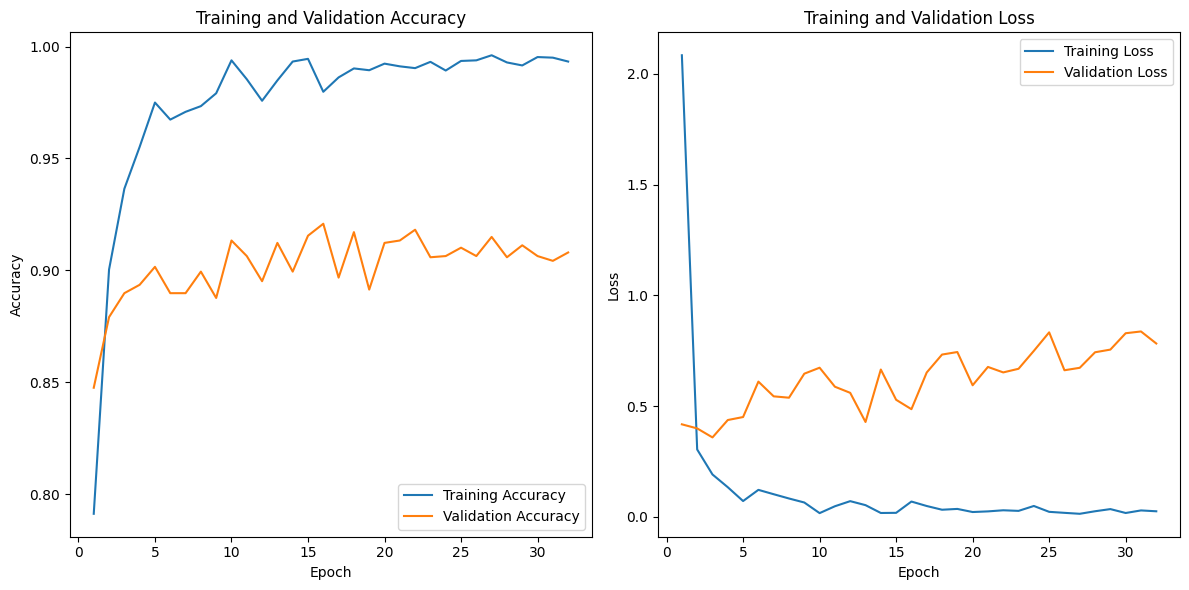

In [13]:
# Plotting accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
epochs = range(1, len(history.history['accuracy']) + 1)
plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()


In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

In [15]:
# Extract features using the CNN model
X_train_features = model.predict(X_train)
X_val_features = model.predict(X_val)

59/59 [==============================] - 9s 148ms/step


In [16]:
# Reshape data for Random Forest
X_train_flatten = X_train_features.reshape(X_train_features.shape[0], -1)
X_val_flatten = X_val_features.reshape(X_val_features.shape[0], -1)

In [17]:
# Initialize Random Forest classifier
random_forest_classifier = RandomForestClassifier(n_estimators=50, random_state=42)

# Train Random Forest classifier
random_forest_classifier.fit(X_train_flatten, y_train_encoded)

# Make predictions on validation set
random_forest_predictions = random_forest_classifier.predict(X_val_flatten)

# Evaluate performance
random_forest_accuracy = metrics.accuracy_score(y_val_encoded, random_forest_predictions)
random_forest_precision = metrics.precision_score(y_val_encoded, random_forest_predictions, average='weighted')
random_forest_recall = metrics.recall_score(y_val_encoded, random_forest_predictions, average='weighted')
random_forest_f1 = metrics.f1_score(y_val_encoded, random_forest_predictions, average='weighted')

# Print results
print("Random Forest (on CNN features): Accuracy = {:.4f}, Precision = {:.4f}, Recall = {:.4f}, F1 Score = {:.4f}".format(random_forest_accuracy, random_forest_precision, random_forest_recall, random_forest_f1))

Random Forest (on CNN features): Accuracy = 0.9085, Precision = 0.9087, Recall = 0.9085, F1 Score = 0.9084


In [18]:
from sklearn.neighbors import KNeighborsClassifier


In [19]:
# Initialize k-NN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=5)  # You can adjust the number of neighbors as needed

# Train k-NN classifier
knn_classifier.fit(X_train_flatten, y_train_encoded)

# Make predictions on the validation set
knn_predictions = knn_classifier.predict(X_val_flatten)

# Evaluate performance
knn_accuracy = metrics.accuracy_score(y_val_encoded, knn_predictions)
knn_precision = metrics.precision_score(y_val_encoded, knn_predictions, average='weighted')
knn_recall = metrics.recall_score(y_val_encoded, knn_predictions, average='weighted')
knn_f1 = metrics.f1_score(y_val_encoded, knn_predictions, average='weighted')

# Print results for k-NN
print("k-Nearest Neighbors (on CNN features): Accuracy = {:.4f}, Precision = {:.4f}, Recall = {:.4f}, F1 Score = {:.4f}".format(knn_accuracy, knn_precision, knn_recall, knn_f1))


k-Nearest Neighbors (on CNN features): Accuracy = 0.9058, Precision = 0.9055, Recall = 0.9058, F1 Score = 0.9055


In [20]:
from sklearn.ensemble import AdaBoostClassifier


In [21]:
# Initialize AdaBoost classifier with a decision tree base estimator
adaboost_classifier = AdaBoostClassifier(n_estimators=50, random_state=42)

# Train AdaBoost classifier
adaboost_classifier.fit(X_train_flatten, y_train_encoded)

# Make predictions on the validation set
adaboost_predictions = adaboost_classifier.predict(X_val_flatten)

# Evaluate performance
adaboost_accuracy = metrics.accuracy_score(y_val_encoded, adaboost_predictions)
adaboost_precision = metrics.precision_score(y_val_encoded, adaboost_predictions, average='weighted')
adaboost_recall = metrics.recall_score(y_val_encoded, adaboost_predictions, average='weighted')
adaboost_f1 = metrics.f1_score(y_val_encoded, adaboost_predictions, average='weighted')

# Print results for AdaBoost
print("AdaBoost (on CNN features): Accuracy = {:.4f}, Precision = {:.4f}, Recall = {:.4f}, F1 Score = {:.4f}".format(adaboost_accuracy, adaboost_precision, adaboost_recall, adaboost_f1))


AdaBoost (on CNN features): Accuracy = 0.9085, Precision = 0.9085, Recall = 0.9085, F1 Score = 0.9081
